# 导入库

In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent.parent)

In [2]:
os.getcwd()

'D:\\LFProjects\\NewPythonProject'

# 权重路径结构

权重文件夹位于weight文件夹中，然后根据权重类别设置子文件夹，目前有EqualWeight, GroupWeight, TimeSeriesWeight, VolWeight， 分别表示等权重、分组权重（仅分组使用）、时间序列权重、波动率权重。每一类权重有许多种类，每个具体的权重构成一个py文件，同时在py文件里实现一个权重类，例如：
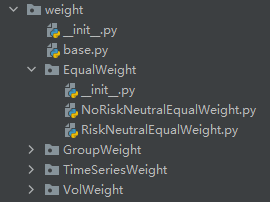

# 如何构建权重

## 权重基类BaseWeight

In [3]:
from weight.base import BaseWeight

### 权重基类BaseWeight的属性和方法

In [4]:
[i for i in dir(BaseWeight) if not i.startswith("__")]

['_abc_impl',
 '_get_param_names',
 'get_params',
 'get_string',
 'get_weight',
 'set_params',
 'set_signal']

1.set_signal: 得到权重首先需要知道信号，通过set_signal设置信号。\
2.get_weight: 经过计算得到权重DataFrame，如果是GroupWeight，则是权重字典。

In [5]:
import inspect
from pathlib import Path
from pandas import DataFrame
from abc import abstractmethod

from bases.base import BaseClass

class BaseWeight(BaseClass):

    def __init__(self, **params) -> None:
        """Constructor"""
        super().__init__(**params)
        self.group: str = Path(inspect.getfile(self.__class__)).parent.name
        self.name: str = self.__class__.__name__
        self.signal_df: DataFrame = None
        self.weight_df: DataFrame = None

    def set_signal(self, signal_df: DataFrame) -> None:
        """
        设置信号DataFrame

        Parameters
        ----------
        signal_df: DataFrame
                    信号DataFrame, index为交易时间, columns为品种代码, data为信号, 做多为1, 做空为-1,空仓为0

        Returns
        -------
        None
        """
        self.signal_df = signal_df

    @abstractmethod
    def get_weight(self) -> DataFrame:
        """
        获取权重
        Returns
        -------
        权重DataFrame
        """
        raise NotImplementedError

    def __repr__(self):
        group = self.group
        name = self.name
        title = ''
        title += f"weight(group={group}, name={name}, "
        # 添加因子参数
        for key, value in self.get_params().items():
            title += f"{key}={value}, "
        title = title[:-2]
        title += ")"
        return title

    def get_string(self) -> str:
        return self.__repr__()

## 单类权重的基类

某些权重会有该类权重的特性，通过定义这类权重的基类，可以简化这类权重的各个具体权重的计算逻辑，常见的情形:\
1.权重在计算时一些代码时公共的。\
2.同类权重中的不同信号都需要同一个获取数据的方法。

In [6]:
import numpy as np
from typing import Dict
from pandas import DataFrame
from abc import abstractmethod
from weight.base import BaseWeight

class BaseGroupWeight(BaseWeight):

    def __init__(self, **params) -> None:
        """Constructor"""
        super().__init__(**params)

    def get_weight(self) -> Dict[int, DataFrame]:
        """
        获取因子的权重DataFrame字典

        Returns
        -------
        weight_df_dict: Dict[int, DataFrame]
                        因子的权重DataFrame字典
        """
        if not isinstance(self.signal_df, DataFrame):
            raise ValueError("Please specify signal df first!")

        signal_df = self.signal_df
        new_signal_df = signal_df.copy()
        new_signal_df[signal_df <= 0.0] = np.nan
        max_num = signal_df.max().max()

        weight_df_dict: Dict[int, DataFrame] = {}
        for i in range(1, int(max_num)+1):
            df = new_signal_df.copy()
            df[df != i] = np.nan
            single_weight_df = self.get_single_weight(df)
            weight_df_dict[i] = single_weight_df

        self.weight_df_dict = weight_df_dict
        return weight_df_dict

    @abstractmethod
    def get_single_weight(self, single_signal_df: DataFrame) -> DataFrame:
        """
        获取因子各组的权重DataFrame

        Parameters
        __________
        signle_signal_df: DataFrame
                            单一组别的信号DataFrame, index为交易时间,columns为品种代码，data为信号

        Returns
        -------
        因子各组的权重DataFrame
        """
        raise NotImplementedError

在分组权重中，由于可以提炼出get_single_weight这个方法，各个具体的分组回测只需要实现get_single_weight即可，不用再实现get_weight了。

## 以NoRiskNeutralEqualWeight为例构建权重

In [7]:
import numpy as np
from pandas import DataFrame
from weight.base import BaseWeight

class NoRiskNeutralEqualWeight(BaseWeight):
    """
    等权重生成器,
    """
    def __init__(self) -> None:
        """Constructor"""
        super().__init__()

    def get_weight(self) -> DataFrame:
        """
        获取权重DataFrame

        Returns
        -------
        weight_df: DataFrame
                    权重DataFrame
        """

        # 预先检查
        if not isinstance(self.signal_df, DataFrame):
            raise ValueError("Please specify signal_df first!")

        signal_df = self.signal_df
        weight_df = (signal_df.T / np.abs(signal_df).sum(axis=1)).T
        self.weight_df = weight_df
        return weight_df

## 分组权重（特殊）

### 分组权重基类



In [9]:
import numpy as np
from typing import Dict
from pandas import DataFrame
from abc import abstractmethod
from weight.base import BaseWeight

class BaseGroupWeight(BaseWeight):

    def __init__(self, **params) -> None:
        """Constructor"""
        super().__init__(**params)

    def get_weight(self) -> Dict[int, DataFrame]:
        """
        获取因子的权重DataFrame字典

        Returns
        -------
        weight_df_dict: Dict[int, DataFrame]
                        因子的权重DataFrame字典
        """
        if not isinstance(self.signal_df, DataFrame):
            raise ValueError("Please specify signal df first!")

        signal_df = self.signal_df
        new_signal_df = signal_df.copy()
        new_signal_df[signal_df <= 0.0] = np.nan
        max_num = signal_df.max().max()

        weight_df_dict: Dict[int, DataFrame] = {}
        for i in range(1, int(max_num)+1):
            df = new_signal_df.copy()
            df[df != i] = np.nan
            single_weight_df = self.get_single_weight(df)
            weight_df_dict[i] = single_weight_df

        self.weight_df_dict = weight_df_dict
        return weight_df_dict

    @abstractmethod
    def get_single_weight(self, single_signal_df: DataFrame) -> DataFrame:
        """
        获取因子各组的权重DataFrame

        Parameters
        __________
        signle_signal_df: DataFrame
                            单一组别的信号DataFrame, index为交易时间,columns为品种代码，data为信号

        Returns
        -------
        因子各组的权重DataFrame
        """
        raise NotImplementedError

In [10]:
from pandas import DataFrame
from weight.GroupWeight.base import BaseGroupWeight

class GroupEqualWeight(BaseGroupWeight):

    def __init__(self, **params) -> None:
        """Constructor"""
        super().__init__(**params)

    def get_single_weight(self, single_signal_df: DataFrame) -> DataFrame:
        """
        获取因子各组的权重DataFrame

        Parameters
        __________
        signle_signal_df: DataFrame
                            单一组别的信号DataFrame, index为交易时间,columns为品种代码，data为信号

        Returns
        -------
        因子各组的权重DataFrame
        """
        single_weight_df = (single_signal_df.T / single_signal_df.sum(axis=1)).T
        return single_weight_df